In [15]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import cv2

In [16]:
def show(img,caption):
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption)
    plt.show()
def calHist(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    return np.argmax(hist)
def remove_lines(img): #Gray scale img
    thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))
    remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(img, [c], -1, (255, 255, 255), 3)
    thresholded_img = cv2.threshold(img, 95, 255, cv2.THRESH_BINARY_INV)[1]
    return thresholded_img
def find_boxes(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    dilated = cv2.dilate(img, kernel, iterations=8)
    
    contours, hierarchy = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    threshold_area = 12000
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > threshold_area]
    boxes = [cv2.boundingRect(cnt) for cnt in contours]
    return boxes
def draw_boxes(img,boxes):
    for box in boxes:
        x, y, w, h = box
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 0), 6)
    return img
def preprocess_img(img):     
    
    # Stretch image
    height, width = img.shape[:2]
    coef = width/height # edit values
    # Define the affine transformation matrix
    matrix = np.float32([[1, 0, 0], [0, coef , 0]])
    # Apply the affine transformation to the image
    img_dilated = cv2.warpAffine(img, matrix, (width, int(height*coef)))
    
    
    # Add blank value 
    most_frequency_value = calHist(img_dilated)
    h_mask = img_dilated.shape[0] 
    mask = np.full((h_mask, int(2*h_mask)), most_frequency_value, dtype = np.uint8) # edit values
    mask[0:img_dilated.shape[0], 0:img_dilated.shape[1]] = img_dilated
    mask= cv2.resize(mask,(128,32))
    return mask

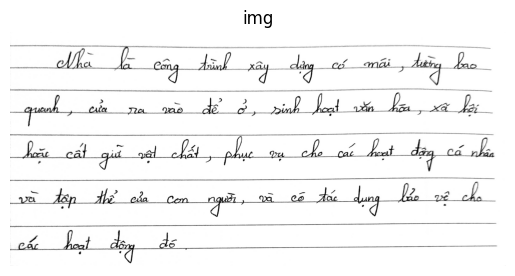

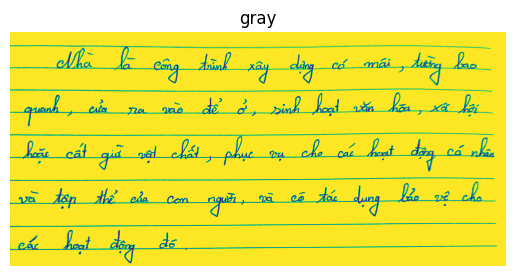

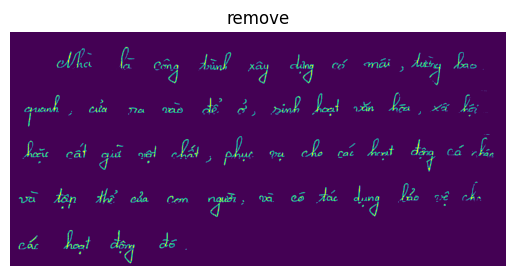

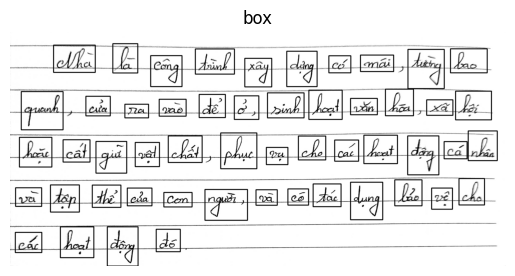

In [17]:
img = cv2.imread(r'./vanban3.png')
show(img,'img')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
show(gray,'gray')

remove_line = remove_lines(gray)
show(remove_line,'remove')

boxes = find_boxes(remove_line)
show(draw_boxes(img,boxes),'box')

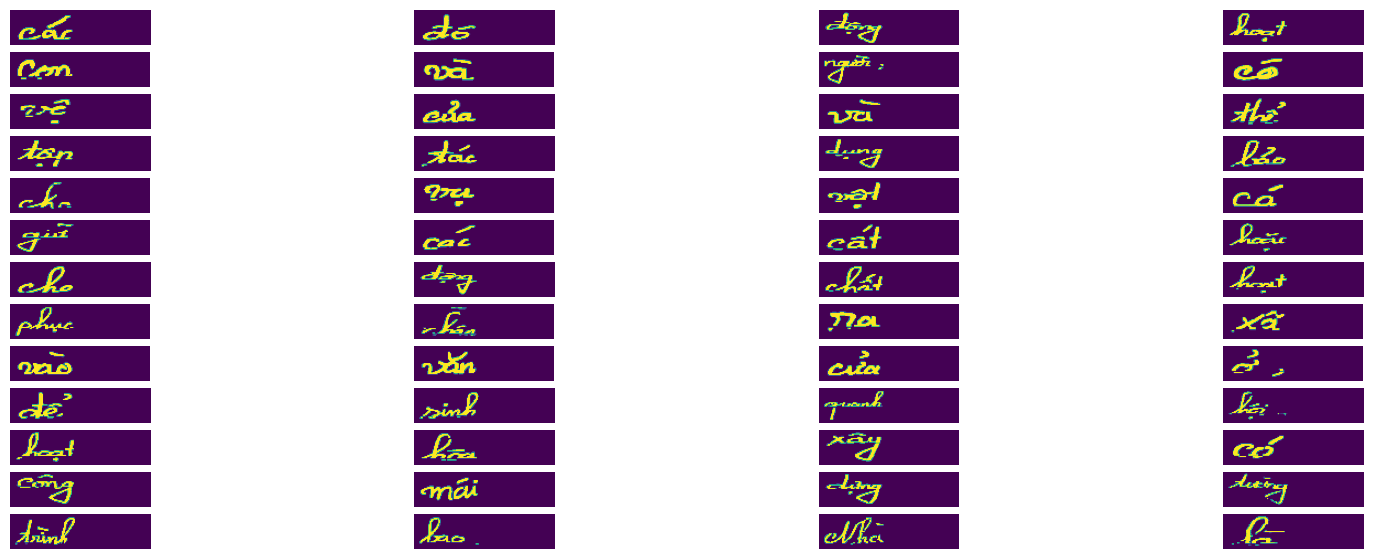

In [18]:
crop_img = []
for box in boxes:
    x, y, w, h = box
    crop_img.append(remove_line[y:y+h, x:x+w])

word_img =[]
plt.figure(figsize=(20,7))
for i,img in enumerate(crop_img):
    plt.subplot(math.ceil(len(crop_img)/4), 4, i+1)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    dilated = cv2.dilate(img, kernel, iterations = 2)
    dilated = preprocess_img(dilated)
    word_img.append(dilated)
    plt.imshow(word_img[i])
    plt.axis('off')

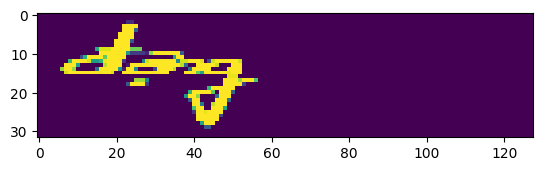

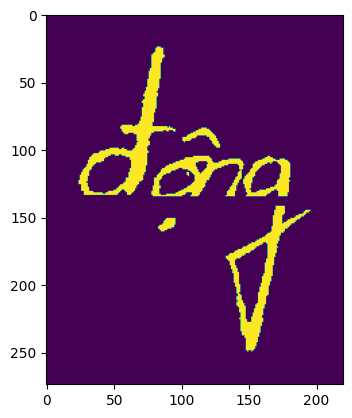

In [50]:
i=25
plt.imshow(word_img[i])
plt.show()
plt.imshow(crop_img[i])
plt.show()

#  Program

In [7]:
alphabets = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYabcdefghijklmnopqrstuvxyzÀÁÂÔÚÝàáâãèéêìíòóôõùúýĂăĐđĩũƒƠơƯưạẢảẤấẦầẩẫậắằẳẵặẹẻẽếỀềỂểễỆệỉịọỏỐốỒồổỗộớờỞởỡợụỦủứừửữựỳỷỹ'
import tensorflow as tf
from tensorflow import keras
model = tf.keras.models.load_model('./word_model_last.h5')
def predict(img):
    preds = model.predict(img)
    decoded = tf.keras.backend.get_value(
        tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0]) * preds.shape[1],
                                    greedy=True)[0][0])
    prediction = []
    for i in range(decoded.shape[0]):
        prediction.append(num_to_label(decoded[i]))
    return prediction

def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret += alphabets[ch]
    return ret

def show(img,caption):
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption)
    plt.show()
    
def calHist(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    return np.argmax(hist)

def remove_lines(img): #Gray scale img
    thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))
    remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(img, [c], -1, (255, 255, 255), 3)
    thresholded_img = cv2.threshold(img, 95, 255, cv2.THRESH_BINARY_INV)[1]
    return thresholded_img

def find_boxes(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    dilated = cv2.dilate(img, kernel, iterations=8)
    
    contours, hierarchy = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    threshold_area = 12000
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > threshold_area]
    boxes = [cv2.boundingRect(cnt) for cnt in contours]
    return boxes

def draw_boxes(img,boxes):
    for box in boxes:
        x, y, w, h = box
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 0), 6)
    return img

def stretch_img(img):     
    
    # Stretch image
    height, width = img.shape[:2]
#     if height>width:
#         coef = height/width # edit values
#     else:
#         coef = width/height
    coef = width/height
    # Define the affine transformation matrix
    matrix = np.float32([[1, 0, 0], [0, coef , 0]])
    # Apply the affine transformation to the image
    img_dilated = cv2.warpAffine(img, matrix, (width, int(height*coef)))
    
    
    # Add blank value 
    most_frequency_value = calHist(img_dilated)
    h_mask = img_dilated.shape[0] 
    mask = np.full((h_mask, int(2*h_mask)), most_frequency_value, dtype = np.uint8) # edit values
    mask[0:img_dilated.shape[0], 0:img_dilated.shape[1]] = img_dilated
    mask= cv2.resize(mask,(128,32))
    return mask

def preprocess_img(crop_img):
    word_img = []
    for img in crop_img:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
        dilated = cv2.dilate(img,kernel,iterations = 1)
        dilated = stretch_img(dilated)
        word_img.append(dilated)
    return word_img

def transform_image(image):
    image = cv2.bitwise_not(image)
    image = (255 - image) * (-7/255)
    result = np.around(image)
    return result

In [11]:
image = cv2.imread(r'./vanban15.png')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
removed_line = remove_lines(gray)
result = removed_line.copy()
boxes = find_boxes(removed_line)

crop_img = []
for box in boxes:
    x, y, w, h = box
    crop_img.append(result[y:y+h, x:x+w])

word_img = preprocess_img(crop_img)

prediction = []
for img in word_img:
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-7, 0))
    scaler = scaler.fit_transform(img)

    img = np.rint(-7-scaler)
    img = np.transpose(img)
    img = img.reshape(-1,128,32,1)
    prediction.append(predict(img))

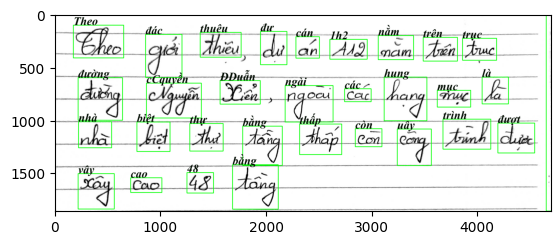

In [12]:
from PIL import Image, ImageFont,ImageDraw
font = ImageFont.truetype(r"C:\Windows\Fonts\Times New Roman\timesbi.ttf", 110)
img = cv2.imread(r'./vanban15.png')

for box in boxes:
    x, y, w, h = box
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 5)
plt.imshow(img)


for i,box in enumerate(boxes):
    x, y, w, h = box
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img)
    draw = ImageDraw.Draw(img_pil)
    draw.text((x,y-100),  prediction[i][0], font = font,fill = (0,10,0))
    img = np.asarray(img_pil)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)